In [8]:
import networkx as nx
import pandas as pd

import pydot
from IPython.core.display import SVG

In [83]:
cdf = pd.read_csv("credit-dynamics.csv").dropna(subset='UID')

In [84]:
cdf.replace(to_replace="CH+", value="CH", inplace=True)
cdf.replace(to_replace="OC/DC", value="OC, DC", inplace=True)
cdf.replace(to_replace="CH+, CD", value="CH, CD", inplace=True)

In [71]:
cdf.columns

Index(['UID', 'Name', 'Actor', 'Algorithm', 'Process', 'Choices (optional)',
       'Effects', 'Regulations', 'Note'],
      dtype='object')

In [72]:
gdf = pd.read_csv("genai-dynamics.csv")
gdf.rename(columns={
    ' ':'UID',
    'Action Name' : 'Name',
    'Actor (optional)' : 'Actor',
    'Effects (Downstream UIDs)' : 'Effects'
}, inplace = True)

In [122]:
gdf
gdf.replace(to_replace="SA/MT", value="SA, MT", inplace=True)
gdf.replace(to_replace="RC/RP/ER", value="RC, RP, ER", inplace=True)
gdf.replace(to_replace="MT (by another model trainer)", value="MT", inplace=True)

In [73]:
gdf.columns

Index(['UID', 'Name', 'Actor', 'Goal (optional)', 'Algorithm (True or False)',
       'Process', 'Choices (optional)', 'Effects', 'Regulations'],
      dtype='object')

In [85]:
def dynamic_df_to_graph(
    df,
    name_label="Name",
    actor_label="Actor",
    effects_label="Effects"
):
    g = nx.DiGraph()

    for row in df.iterrows():
        uid = row[1]['UID']

        name = row[1][name_label]
        actor = row[1][actor_label]

        #algorithm = row[1]['Algorithm']
        #regulations = row[1]['Regulations']

        data = {
            'long_name' : name,
            'actor' : actor,
            #'algorithm' : algorithm,
            #'regulations': regulations
        }
    
        # print(data) 
        g.add_node(uid, **data)
    
        # print(dict(g.nodes(data=True)))
    
    for row in df.iterrows():
        tail = row[1]['UID']
        for head in row[1]['Effects'].split(','):
            g.add_edge(tail, head.strip())
            
    return g

In [123]:
cg = dynamic_df_to_graph(cdf)
gag = dynamic_df_to_graph(gdf)

In [87]:
cg.nodes(data=True)

NodeDataView({'AC': {'long_name': 'Accept Credit', 'actor': 'Borrower'}, 'AP': {'long_name': 'Apply for Credit', 'actor': 'Borrower'}, 'RI': {'long_name': 'Request for Information from applicant', 'actor': 'Lender'}, 'EC': {'long_name': 'Evaluate for Credit', 'actor': 'Lender'}, 'DC': {'long_name': 'Decline to Offer Credit', 'actor': 'Lender'}, 'OC': {'long_name': 'Offer Credit', 'actor': 'Lender'}, 'PB': {'long_name': 'Pay Back ', 'actor': 'Borrower'}, 'CD': {'long_name': 'Collect Debt', 'actor': 'Lender'}, 'CH': {'long_name': 'Credit History', 'actor': 'Borrower'}, 'LE': {'long_name': 'Life Events', 'actor': 'Borrower'}, 'CS': {'long_name': 'Credit Scoring', 'actor': 'Credit Scorer'}, 'SC': {'long_name': 'Social Contagion', 'actor': nan}, 'PD': {'long_name': 'Personal data', 'actor': 'Borrower'}, 'PA ': {'long_name': 'Protected Attributes', 'actor': 'Borrower'}})

In [88]:
cg.edges()

OutEdgeView([('AC', 'AP'), ('AC', 'PB'), ('AP', 'RI'), ('RI', 'EC'), ('EC', 'OC'), ('EC', 'DC'), ('DC', 'CH'), ('OC', 'AC'), ('OC', 'CH'), ('PB', 'CH'), ('PB', 'CD'), ('CD', 'CH'), ('CH', 'CS'), ('CH', 'SC'), ('LE', 'CS'), ('LE', 'PD'), ('LE', 'SC'), ('CS', 'EC'), ('SC', 'PD'), ('PD', 'CS'), ('PA ', 'SC'), ('PA ', 'LE')])

In [102]:
credit_actor_style = {
    'Lender' : {'fillcolor': 'aliceblue'},
    'Borrower' : {'fillcolor': 'beige'},
    'Credit Scorer' : {'fillcolor': 'gold'}
}

In [127]:
def dot_dynamics(dg, actor_style = {}):
    dot = pydot.Dot()                                                           
    dot.set('rankdir', 'TB')                                                    
    dot.set('concentrate', True)                                                
    dot.set_node_defaults(shape='record')
    
    for uid, dat in dg.nodes(data=True):
        if 'long_name' in dat:
            node = pydot.Node(
                uid,
                label = dat['long_name']
            )

            print(dat['actor'])
            if dat['actor'] in actor_style:
                for attr in actor_style[dat['actor']]:
                    node.set(attr, actor_style[dat['actor']][attr])
            
            dot.add_node(node)
        
    for e in dg.edges():
        dot.add_edge(
            pydot.Edge(e[0],e[1]))

    for n in dot.get_nodes():
        n.set('style', 'filled')
        #n.set('fillcolor', 'aliceblue')
        n.set('fontsize', '10')
        n.set('fontname', 'Trebuchet MS, Tahoma, Verdana, Arial, Helvetica, sans-serif')

    return dot

In [114]:
#SVG(data = dot_dynamics(gag).create_svg())

Borrower
fillcolor
Borrower
fillcolor
Lender
fillcolor
Lender
fillcolor
Lender
fillcolor
Lender
fillcolor
Borrower
fillcolor
Lender
fillcolor
Borrower
fillcolor
Borrower
fillcolor
Credit Scorer
fillcolor
nan
Borrower
fillcolor
Borrower
fillcolor


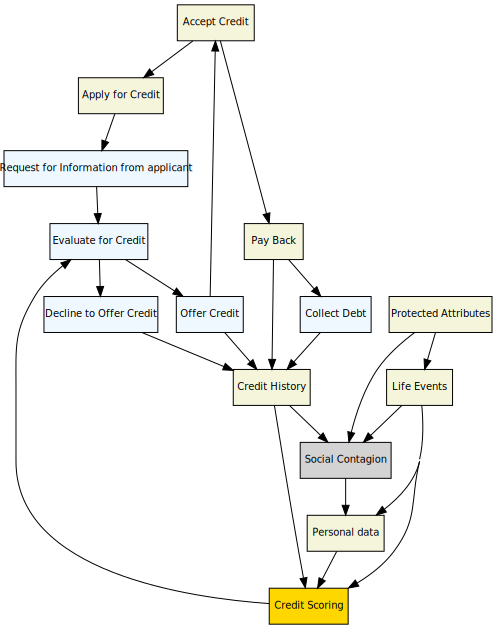

In [115]:
SVG(data = dot_dynamics(
    cg, actor_style = credit_actor_style).create_svg()
)

In [128]:
genai_actor_style = {
    'Internet consumer/user' : {'fillcolor': 'beige'},
    'Data controller/processor' : {'fillcolor': 'lightblue'},
    'Data controller' : {'fillcolor': 'lightblue1'},
    'Data controller/processor (AI finetuner)' : {'fillcolor': 'lightblue2'},
    '... (AI finetuner)' : {'fillcolor': 'lightblue2'},
    'Data controller/processor (AI model trainer)' : {'fillcolor': 'lightblue3'},
    '(AI model trainer)' : {'fillcolor': 'lightblue3'},
    'GenAI service user' : {'fillcolor': 'lightyellow'}
}


Internet consumer/user
Internet consumer/user
Internet consumer/user
Internet consumer/user
Data controller/processor
Data controller/processor
Data controller
Data controller/processor (AI model trainer)
(AI model trainer)
... (AI finetuner)
Data controller/processor (AI finetuner)
Data controller
GenAI service user
Data controller
GenAI service user
GenAI service user
Data controller/processor
Data controller/processor
Data controller/processor
Internet consumer/user


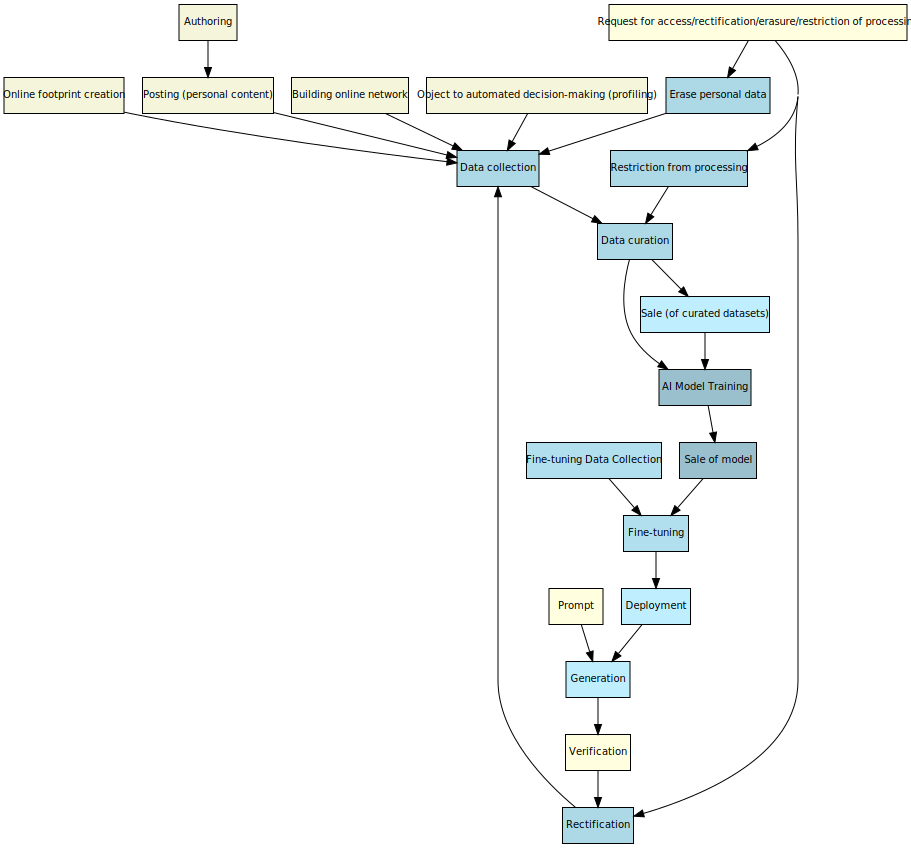

In [129]:
SVG(data = dot_dynamics(
    gag, actor_style = genai_actor_style).create_svg()
)

In [130]:
dot_dynamics(gag, actor_style = genai_actor_style).write_png('genai_dot.png')

Internet consumer/user
Internet consumer/user
Internet consumer/user
Internet consumer/user
Data controller/processor
Data controller/processor
Data controller
Data controller/processor (AI model trainer)
(AI model trainer)
... (AI finetuner)
Data controller/processor (AI finetuner)
Data controller
GenAI service user
Data controller
GenAI service user
GenAI service user
Data controller/processor
Data controller/processor
Data controller/processor
Internet consumer/user
